**Version Note**: Dataset now includes encoding of Race variable (RACE_WHITE, RACE_BLACK, RACE_OTHER). Also still .includes non-encoded variable ('RACE_MOD')

In [1]:
import pandas as pd
# import pipeline as p
# import cleaning as c
import util as u

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
# import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

import numpy as np

In [51]:
# from lifelines import statistics as lfstat

In [2]:
# df = u.open_pkl('Data/df_survival_analysis.pkl')
X_train = u.open_pkl('Data/X_train_SA.pkl')
y_train = u.open_pkl('Data/y_train_SA.pkl')
X_test = u.open_pkl('Data/X_test_SA.pkl')
y_test = u.open_pkl('Data/y_test_SA.pkl')

In [3]:
df = X_train.join(y_train)

In [112]:
df.head()

,MAR_STAT_MOD,RACE_MOD,AGE_DX,GRADE,TUMSIZ,SURG,SEQ_NUM,POS_NODES,HST_STGA,INVAS,SRV_TIME_MON,RACE_WHITE,RACE_BLACK,RACE_OTHER,DEATH
0,0.0,01,60.0,4.0,27.0,1.0,0.0,0.0,0.0,0,73.0,1,0,0,0
1,1.0,01,49.0,1.0,7.0,1.0,1.0,0.0,1.0,1,112.0,1,0,0,0
2,0.0,01,79.0,3.0,51.0,1.0,1.0,0.0,1.0,1,64.0,1,0,0,1
3,1.0,01,66.0,3.0,30.0,1.0,0.0,0.0,2.0,1,3.0,1,0,0,0
4,1.0,03,38.0,3.0,31.0,1.0,0.0,1.0,2.0,1,40.0,0,0,1,0


### Kaplan-Meier

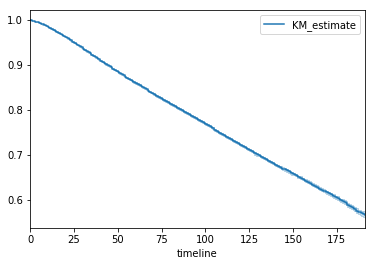

In [8]:
observations = df['DEATH']
durations = df['SRV_TIME_MON']

kmf = KaplanMeierFitter()
kmf.fit(durations=durations, event_observed=observations)

kmf.plot();

In [9]:
kmf.median_

inf

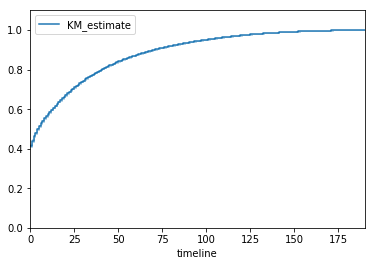

In [33]:
kmf = KaplanMeierFitter()

kmf.fit(durations=durations, event_observed=observations, left_censorship=True)

kmf.plot(); # CDF
plt.axis([0,190,0,1.1]);

In [31]:
kmf.median_

5.0

### Cox Proportional Hazards

In [24]:
cph = CoxPHFitter()

cph.fit(df=df.drop(columns=['RACE_WHITE', 'RACE_BLACK', 'RACE_OTHER']), duration_col='SRV_TIME_MON', 
        event_col='DEATH', strata='RACE_MOD', show_progress=True)

Iteration 1: norm_delta = 0.89747, step_size = 0.95000, ll = -523668.29863, newton_decrement = 21751.88950, seconds_since_start = 0.7
Iteration 2: norm_delta = 0.44925, step_size = 0.95000, ll = -583708.11756, newton_decrement = 98408.21501, seconds_since_start = 1.3
Iteration 3: norm_delta = 0.35526, step_size = 0.95000, ll = -509983.07810, newton_decrement = 4726.00866, seconds_since_start = 2.0
Iteration 4: norm_delta = 0.11791, step_size = 0.95000, ll = -505919.44648, newton_decrement = 688.58277, seconds_since_start = 2.7
Iteration 5: norm_delta = 0.03701, step_size = 0.95000, ll = -505148.76003, newton_decrement = 67.92702, seconds_since_start = 3.4
Iteration 6: norm_delta = 0.00614, step_size = 0.95000, ll = -505076.01636, newton_decrement = 2.66942, seconds_since_start = 4.1
Iteration 7: norm_delta = 0.00052, step_size = 0.95000, ll = -505073.28608, newton_decrement = 0.02408, seconds_since_start = 4.7
Iteration 8: norm_delta = 0.00003, step_size = 0.95000, ll = -505073.26199, 

<lifelines.CoxPHFitter: fitted with 236371 observations, 189372 censored>

In [5]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 236371 observations, 189372 censored>
      duration col = 'SRV_TIME_MON'
         event col = 'DEATH'
            strata = RACE_MOD
number of subjects = 236371
  number of events = 46999
    log-likelihood = -505073.26
  time fit was run = 2019-01-28 19:37:36 UTC

---
              coef  exp(coef)  se(coef)      z      p  log(p)  lower 0.95  upper 0.95     
MAR_STAT_MOD -0.31       0.73      0.01 -32.38 <0.005 -527.92       -0.33       -0.29  ***
AGE_DX        0.05       1.05      0.00 128.74 <0.005    -inf        0.05        0.05  ***
GRADE         0.27       1.31      0.01  42.63 <0.005    -inf        0.26        0.28  ***
TUMSIZ        0.00       1.00      0.00  45.88 <0.005    -inf        0.00        0.00  ***
SURG         -0.89       0.41      0.05 -17.49 <0.005 -156.01       -0.99       -0.79  ***
SEQ_NUM       0.18       1.20      0.01  33.85 <0.005 -576.62        0.17        0.19  ***
POS_NODES     0.05       1.05      0.00  48.85 <0.005    

/Users/kendra/survival/lib/python3.6/site-packages/lifelines/fitters/coxph_fitter.py:1113: RuntimeWarning: divide by zero encountered in log
  df["log(p)"] = np.log(df["p"])


Concordance = 0.75
Likelihood ratio test = 85503.49 on 9 df, log(p)=-inf


/Users/kendra/survival/lib/python3.6/site-packages/lifelines/fitters/coxph_fitter.py:1113: RuntimeWarning: divide by zero encountered in log
  df["log(p)"] = np.log(df["p"])


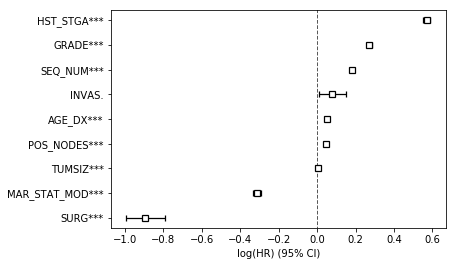

In [6]:
cph.plot()

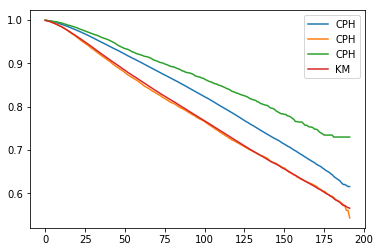

In [30]:
plt.plot(cph.baseline_survival_, label='CPH')
plt.plot(kmf.survival_function_, label='KM')
plt.legend();

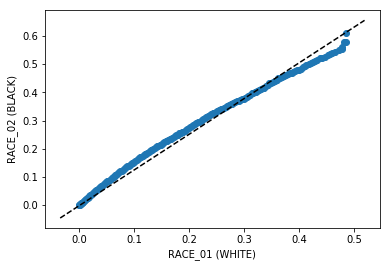

In [37]:
plt.scatter(x=cph.baseline_cumulative_hazard_[['01']], y=cph.baseline_cumulative_hazard_[['02']])
ax = plt.gca()
plt.plot(ax.get_xlim(), ax.get_ylim(), color='k', ls='--')
plt.xlabel('RACE_01 (WHITE)')
plt.ylabel('RACE_02 (BLACK)');

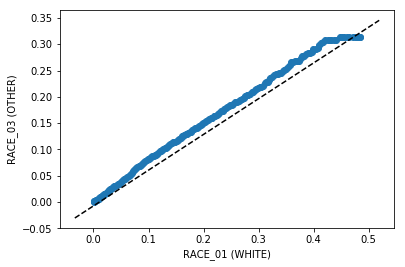

In [38]:
plt.scatter(x=cph.baseline_cumulative_hazard_[['01']], y=cph.baseline_cumulative_hazard_[['03']])
ax = plt.gca()
plt.plot(ax.get_xlim(), ax.get_ylim(), color='k', ls='--')
plt.xlabel('RACE_01 (WHITE)')
plt.ylabel('RACE_03 (OTHER)');

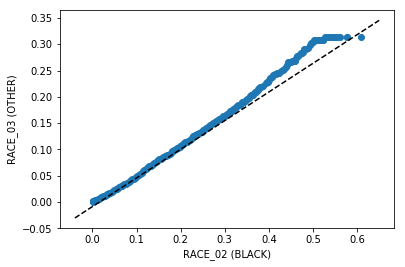

In [39]:
plt.scatter(x=cph.baseline_cumulative_hazard_[['02']], y=cph.baseline_cumulative_hazard_[['03']])
ax = plt.gca()
plt.plot(ax.get_xlim(), ax.get_ylim(), color='k', ls='--')
plt.xlabel('RACE_02 (BLACK)')
plt.ylabel('RACE_03 (OTHER)');

Some non-linearity suggests Race strata may not be proportional

#### Strata by Mariage Status

In [40]:
cph = CoxPHFitter()

cph.fit(df=df.drop(columns=['RACE_WHITE', 'RACE_BLACK', 'RACE_OTHER', 'RACE_MOD']), duration_col='SRV_TIME_MON', 
        event_col='DEATH', strata='MAR_STAT_MOD', show_progress=True)

Iteration 1: norm_delta = 0.85436, step_size = 0.95000, ll = -513040.14022, newton_decrement = 19046.78075, seconds_since_start = 0.5
Iteration 2: norm_delta = 0.53537, step_size = 0.95000, ll = -573669.23377, newton_decrement = 95275.74085, seconds_since_start = 1.0
Iteration 3: norm_delta = 0.49149, step_size = 0.95000, ll = -504673.61024, newton_decrement = 7547.56862, seconds_since_start = 1.5
Iteration 4: norm_delta = 0.13803, step_size = 0.95000, ll = -497531.55923, newton_decrement = 748.36193, seconds_since_start = 1.9
Iteration 5: norm_delta = 0.03614, step_size = 0.95000, ll = -496705.11841, newton_decrement = 57.92166, seconds_since_start = 2.4
Iteration 6: norm_delta = 0.00482, step_size = 0.95000, ll = -496643.71262, newton_decrement = 2.02406, seconds_since_start = 3.0
Iteration 7: norm_delta = 0.00041, step_size = 0.95000, ll = -496641.63599, newton_decrement = 0.02062, seconds_since_start = 3.5
Iteration 8: norm_delta = 0.00002, step_size = 0.95000, ll = -496641.61535, 

<lifelines.CoxPHFitter: fitted with 236371 observations, 189372 censored>

In [41]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 236371 observations, 189372 censored>
      duration col = 'SRV_TIME_MON'
         event col = 'DEATH'
            strata = MAR_STAT_MOD
number of subjects = 236371
  number of events = 46999
    log-likelihood = -496641.62
  time fit was run = 2019-01-28 19:59:42 UTC

---
           coef  exp(coef)  se(coef)      z      p  log(p)  lower 0.95  upper 0.95     
AGE_DX     0.05       1.05      0.00 127.81 <0.005    -inf        0.05        0.05  ***
GRADE      0.28       1.32      0.01  44.05 <0.005    -inf        0.27        0.29  ***
TUMSIZ     0.00       1.00      0.00  46.36 <0.005    -inf        0.00        0.00  ***
SURG      -0.90       0.41      0.05 -17.58 <0.005 -157.68       -1.00       -0.80  ***
SEQ_NUM    0.18       1.20      0.01  33.42 <0.005 -562.22        0.17        0.19  ***
POS_NODES  0.05       1.05      0.00  48.20 <0.005    -inf        0.05        0.05  ***
HST_STGA   0.58       1.78      0.01  62.19 <0.005    -inf        0.56    

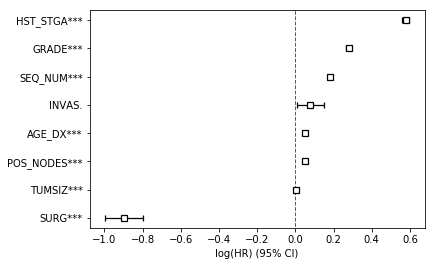

In [42]:
cph.plot()

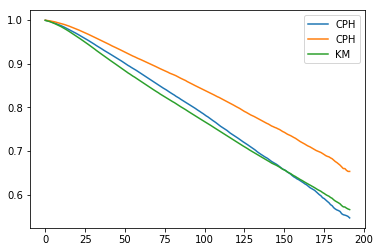

In [43]:
plt.plot(cph.baseline_survival_, label='CPH')
plt.plot(kmf.survival_function_, label='KM')
plt.legend();

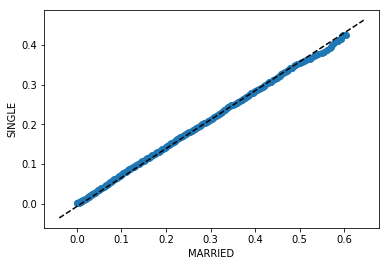

In [46]:
plt.scatter(x=cph.baseline_cumulative_hazard_[[0]], y=cph.baseline_cumulative_hazard_[[1]])
ax = plt.gca()
plt.plot(ax.get_xlim(), ax.get_ylim(), color='k', ls='--')
plt.xlabel('MARRIED')
plt.ylabel('SINGLE');

Appears to meet proportional hazard assumption

#### No strata

Must drop one of the one-hot-encoded columns; otherwise get 'LinAlg Error': Matrix is singular

In [15]:
df_cph = df.drop(columns=['RACE_MOD', 'RACE_WHITE'])

In [16]:
cph = CoxPHFitter()
cph.fit(df=df_cph, duration_col='SRV_TIME_MON', event_col='DEATH', 
        show_progress=True)

Iteration 1: norm_delta = 0.90534, step_size = 0.95000, ll = -547825.00800, newton_decrement = 22306.17420, seconds_since_start = 0.4
Iteration 2: norm_delta = 0.72384, step_size = 0.95000, ll = -623268.68127, newton_decrement = 137397.26801, seconds_since_start = 0.8
Iteration 3: norm_delta = 0.67588, step_size = 0.95000, ll = -540925.68187, newton_decrement = 12430.20277, seconds_since_start = 1.2
Iteration 4: norm_delta = 0.23421, step_size = 0.95000, ll = -534901.97262, newton_decrement = 4405.78410, seconds_since_start = 1.6
Iteration 5: norm_delta = 0.10523, step_size = 0.95000, ll = -529798.93170, newton_decrement = 849.18075, seconds_since_start = 2.0
Iteration 6: norm_delta = 0.04134, step_size = 0.95000, ll = -528832.70730, newton_decrement = 108.82090, seconds_since_start = 2.3
Iteration 7: norm_delta = 0.01099, step_size = 0.95000, ll = -528714.27232, newton_decrement = 6.20996, seconds_since_start = 2.7
Iteration 8: norm_delta = 0.00140, step_size = 0.95000, ll = -528707.8

<lifelines.CoxPHFitter: fitted with 236371 observations, 189372 censored>

In [17]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 236371 observations, 189372 censored>
      duration col = 'SRV_TIME_MON'
         event col = 'DEATH'
number of subjects = 236371
  number of events = 46999
    log-likelihood = -528707.74
  time fit was run = 2019-01-28 19:42:36 UTC

---
              coef  exp(coef)  se(coef)      z      p  log(p)  lower 0.95  upper 0.95     
MAR_STAT_MOD -0.31       0.73      0.01 -32.30 <0.005 -525.25       -0.33       -0.29  ***
AGE_DX        0.05       1.05      0.00 128.74 <0.005    -inf        0.05        0.05  ***
GRADE         0.27       1.31      0.01  42.52 <0.005    -inf        0.26        0.28  ***
TUMSIZ        0.00       1.00      0.00  45.89 <0.005    -inf        0.00        0.00  ***
SURG         -0.89       0.41      0.05 -17.51 <0.005 -156.47       -0.99       -0.79  ***
SEQ_NUM       0.18       1.20      0.01  33.71 <0.005 -572.06        0.17        0.19  ***
POS_NODES     0.05       1.05      0.00  48.94 <0.005    -inf        0.05        0.05  

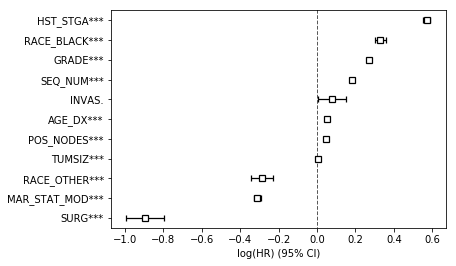

In [18]:
cph.plot()

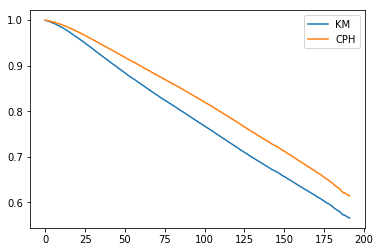

In [19]:
plt.plot(kmf.survival_function_, label='KM')
plt.plot(cph.baseline_survival_, label='CPH')
plt.legend();


<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
                       test_statistic      p  log(p)     
AGE_DX       identity          600.62 <0.005 -303.74  ***
             km                603.83 <0.005 -305.34  ***
             log                  nan    nan     nan     
             rank              509.62 <0.005 -258.16  ***
GRADE        identity          790.61 <0.005 -398.87  ***
             km                805.82 <0.005 -406.48  ***
             log                  nan    nan     nan     
             rank              831.38 <0.005 -419.28  ***
HST_STGA     identity          506.90 <0.005 -256.79  ***
             km                515.09 <0.005 -260.89  ***
             log                  nan    nan     nan     
             rank              578.82 <0.005 -292.82  ***
INVAS        identity            1.83   0.18   -1.74     
             km                  1.83   0.18   -1.

KeyboardInterrupt: 

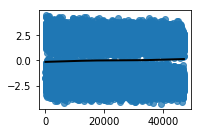

In [144]:
cph.check_assumptions(df_cph) #, show_plots=False)

### Residuals 
How to interpret residuals:
- Pos = patient died sooner than expected (according to model)
- Neg = patient lived longer than expected  or was censored

#### Martingale

In [147]:
resid_m = cph.compute_residuals(df_cph, kind='martingale')


In [148]:
resid_m.head()

,SRV_TIME_MON,DEATH,martingale
14148,0.0,False,-0.000482
113878,0.0,False,-0.000077
79400,0.0,False,-0.000059
5835,0.0,False,-0.000308
228397,0.0,False,-0.000459


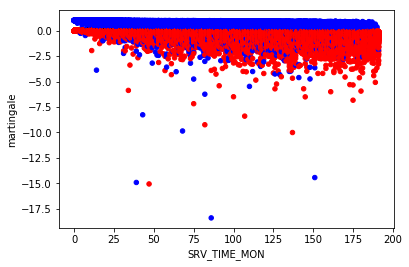

In [150]:
resid_m.plot.scatter(x='SRV_TIME_MON', y='martingale', c=np.where(resid_m['DEATH'], 'blue', 'red'))

#### Deviance

In [151]:
resid_d = cph.compute_residuals(df_cph, kind='deviance')

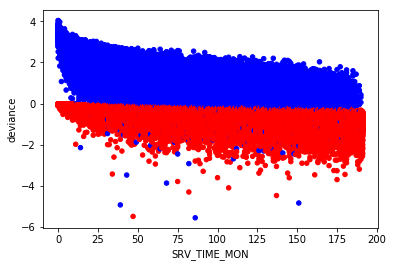

In [153]:
resid_d.plot.scatter(x='SRV_TIME_MON', y='deviance', c=np.where(resid_d['DEATH'], 'blue', 'red'))